In [1]:
# === PARETO FRONT STUDIES NOTEBOOK #4 ===

# Basically the from_weights.ipynb notebook + regularizer custom loss

# == Before running:
# Set the fingerprint generated on nb #3
# Set the "tfrecords_dir_validation" path accordingly

In [2]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import submitit

import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.utils import Sequence
from qkeras import *

from models_16x16.models import *
from OptimizedDataGenerator_v2 import OptimizedDataGenerator
from tensorflow.keras import layers, models

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-07-24 01:02:19.333866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 01:02:19.333951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 01:02:19.335081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 01:02:19.342434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-24 01:02:20.253596: W tensorflow/compiler/tf2

In [3]:
# Custom loss: NLL and a sum of standard deviations sigma regularizer (you can modify the regularizer).

current_reg_weight = tf.Variable(0.0, trainable=False, dtype=tf.float32, name='reg_weight')

def custom_loss(y, p_base, minval=1e-9, maxval=1e9, scale = 512):

    reg_weight = current_reg_weight
    
    p = p_base
    
    mu = p[:, 0:8:2]
    
    # creating each matrix element in 4x4
    Mdia = minval + tf.math.maximum(p[:, 1:8:2], 0.0)
    Mcov = p[:,8:]
    
    # placeholder zero element
    zeros = tf.zeros_like(Mdia[:,0])
    
    # assembles scale_tril matrix
    row1 = tf.stack([Mdia[:,0],zeros,zeros,zeros])
    row2 = tf.stack([Mcov[:,0],Mdia[:,1],zeros,zeros])
    row3 = tf.stack([Mcov[:,1],Mcov[:,2],Mdia[:,2],zeros])
    row4 = tf.stack([Mcov[:,3],Mcov[:,4],Mcov[:,5],Mdia[:,3]])

    scale_tril = tf.transpose(tf.stack([row1,row2,row3,row4]),perm=[2,0,1])

    dist = tfp.distributions.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril) 
    
    likelihood = dist.prob(y)  
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)

    cov_matrix = tf.matmul(scale_tril, tf.transpose(scale_tril, [0, 2, 1])) 
    variances = tf.linalg.diag_part(cov_matrix)
    stds = tf.sqrt(variances + minval)

    sigma_regularizer_1 = tf.reduce_sum(stds, axis=1)

    batch_size = tf.shape(y)[0]
    
    track_loss_values(NLL, sigma_regularizer_1)

    total_loss = NLL + (sigma_regularizer_1 * reg_weight)
    
    return tf.keras.backend.sum(total_loss)

In [4]:
# compiles model
model = CreateModel((16,16,2), n_filters=5, pool_size=3)
model.summary()

2025-07-24 01:02:23.402013: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 14, 14, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 14, 14, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 14, 14, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 14, 14, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 4, 4, 5)           0     

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss)

In [6]:
print(os.getcwd())
print("Subcarpetas y archivos:")
print(os.listdir('./model_batchnorm'))

/home/callea/smart-pixels-ml
Subcarpetas y archivos:
['weights-50x12P5x100_bnorm-checkpoints', 'models_bnorm.py', '.ipynb_checkpoints']


In [7]:
# == Set fingerprint
fingerprint = '28dff4ea'
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

In [8]:
print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)

Loading model from ./trained_models/model-28dff4ea-checkpoints/weights.993-t-22452.66-v-22591.64.hdf5


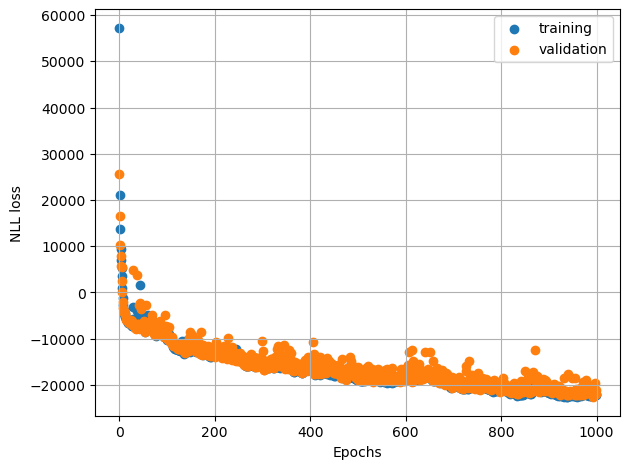

In [9]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.tight_layout() 
plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [10]:
training_history

,epoch,loss,val_loss
0,0,57219.203125,25680.738281
1,1,21089.341797,16520.945312
2,2,13697.408203,10242.180664
3,3,9390.041992,7869.949219
4,4,6956.658203,5771.687500
...,...,...,...
995,995,-22310.210938,-21020.640625
996,996,-21830.283203,-22030.910156
997,997,-21920.953125,-19655.351562
998,998,-21995.669922,-21101.814453


In [11]:
# == Set validation TFrecord path
tfrecords_dir_validation = "/home/callea/TFrecords_3src_filtered/test"

test_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation,
    shuffle = True,
    seed = 13,
    quantize = True
)

Loading metadata from /home/callea/TFrecords_3src_filtered/test/metadata.json


In [12]:
# predicts test data
p_test = model.predict(test_generator)

 4/14 [=======>......................] - ETA: 0s

2025-07-24 01:02:26.742269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


14/14 [==============================] - 1s 77ms/step


In [13]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 14/14 [00:00<00:00, 15.63it/s]


In [14]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]

df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

# residuals (mean, stdv)

In [15]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(0.17280596075579524, 8.987554907798767)

In [16]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-0.03204058884875849, 2.230022521689534)

In [17]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(0.015914959833025932, 0.40785500407218933)

In [18]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(0.003676521359011531, 0.026728671044111252)

# x residuals

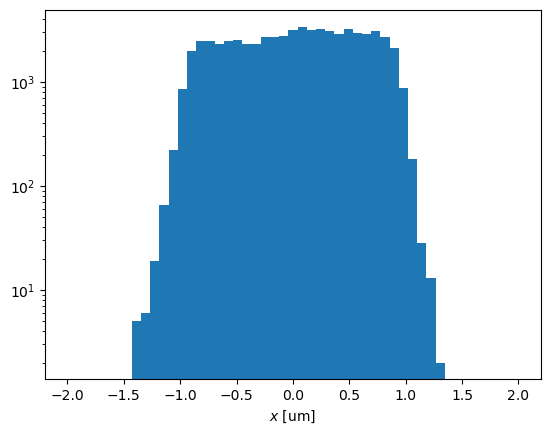

In [19]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

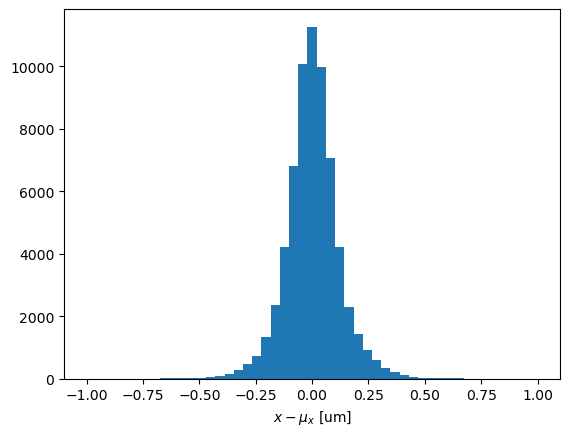

In [20]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

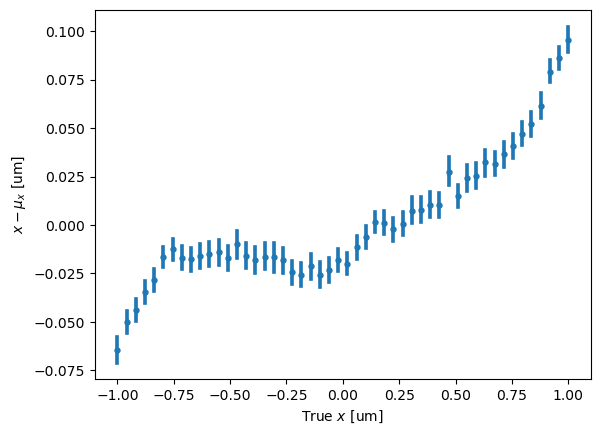

In [21]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

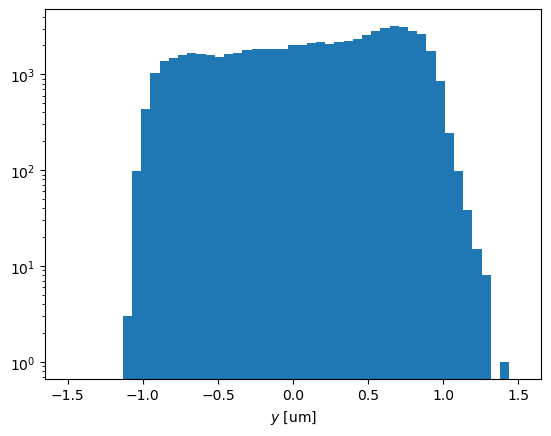

In [22]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

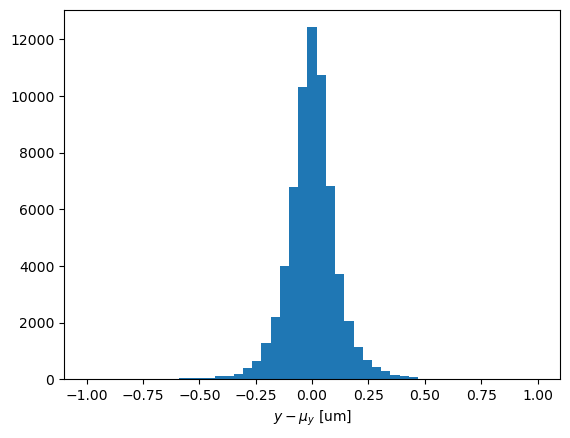

In [23]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

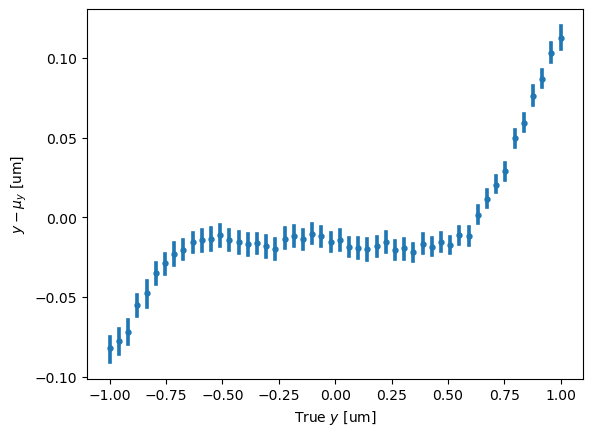

In [24]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

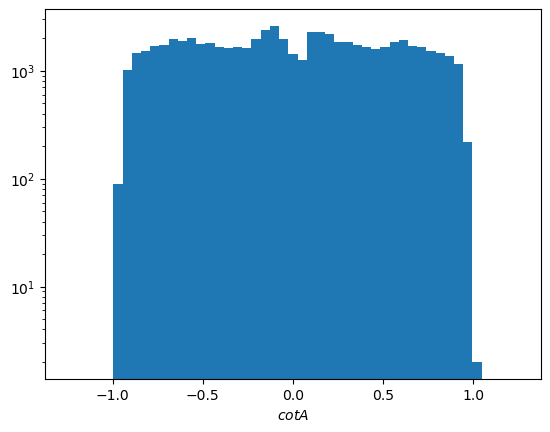

In [25]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

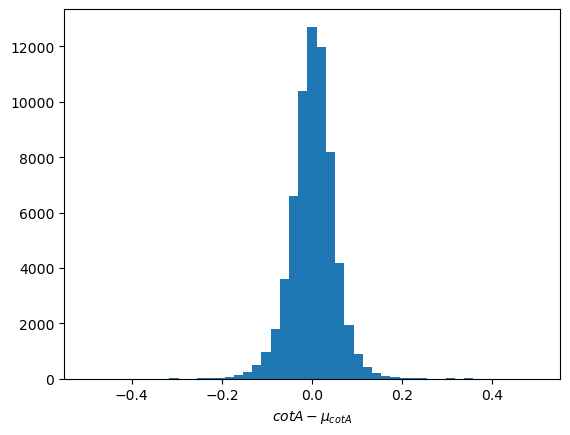

In [26]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

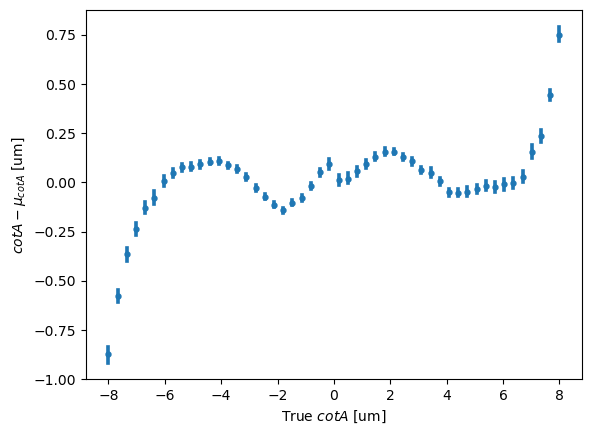

In [27]:
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

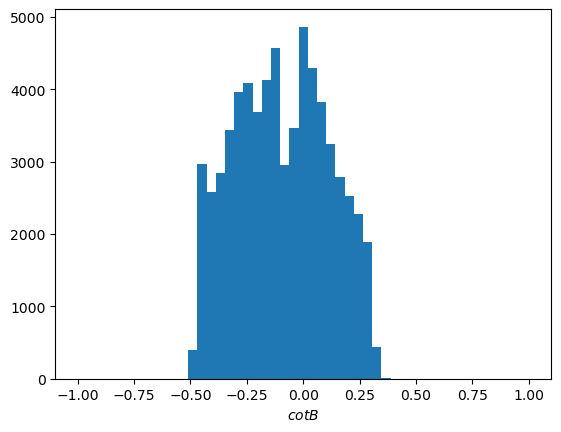

In [28]:
plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

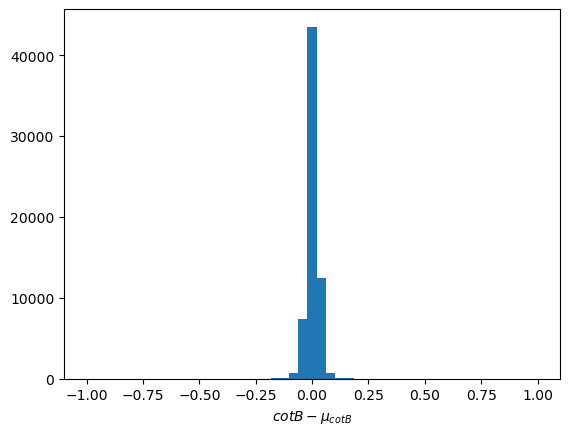

In [29]:
plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

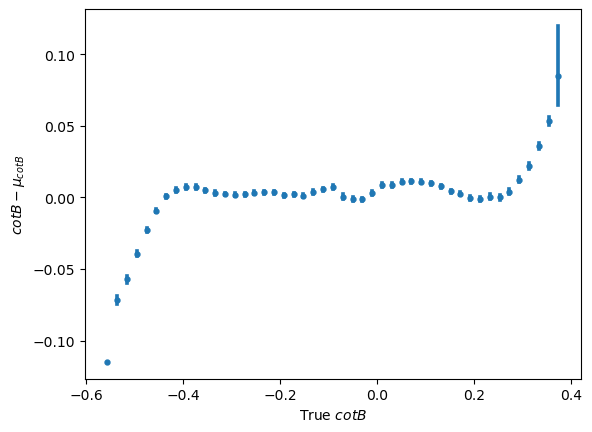

In [30]:
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [31]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

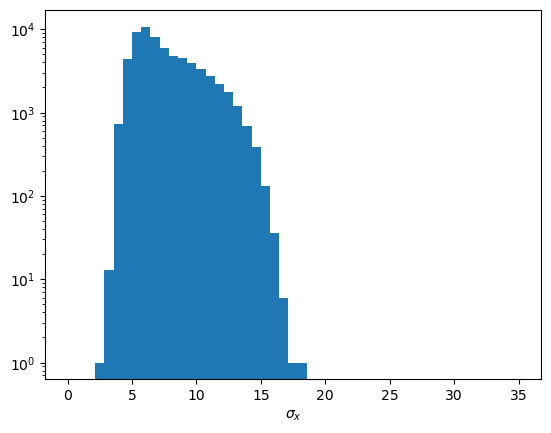

In [32]:
plt.hist(df['sigmax'] * 75,bins=np.linspace(0,35,50))
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

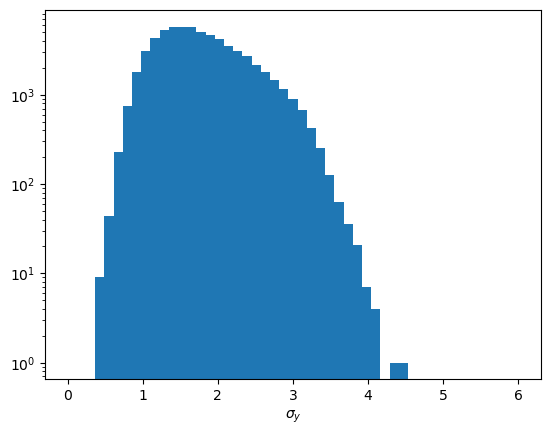

In [33]:
plt.hist(df['sigmay']* 18.75,bins=np.linspace(0,6,50))
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

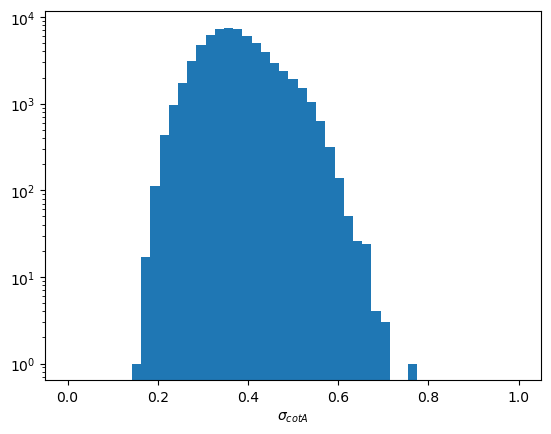

In [34]:
plt.hist(df['sigmacotA'] * 8,bins=np.linspace(0,1.0,50))
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

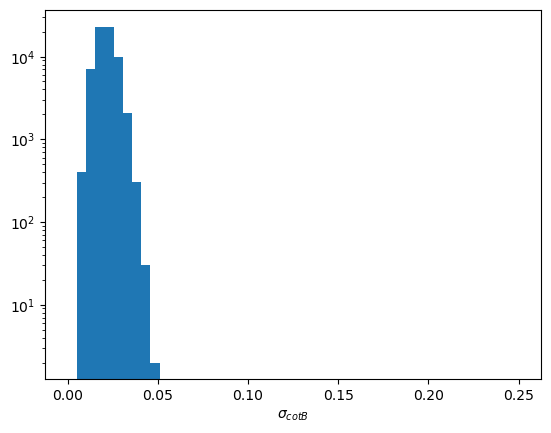

In [35]:
plt.hist(df['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50))
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [36]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name, unit_gauss = True, log_scale = True):
    
    h = ax.hist(df[var],bins=np.linspace(-10,10,50),histtype='step')
    ax.set_xlabel(name)
    if log_scale: ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-10,10,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black', label='Fitted Gaussian')
    if unit_gauss: ax.plot(xbins,gauss(xbins,pars[0],0, 1),color='red', label='Unit Gaussian')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-10,20000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-10,10000,"$\sigma$="+str(round(abs(pars[2]),2)))

    ax.legend()


Mean -0.13543880232789157
Sigma -1.0006895713818873
Mean -0.13852056910672148
Sigma -0.981550689826246
Mean -0.06731007765040035
Sigma 0.9037435387288503
Mean 0.07994456944677378
Sigma 0.9620190571264141


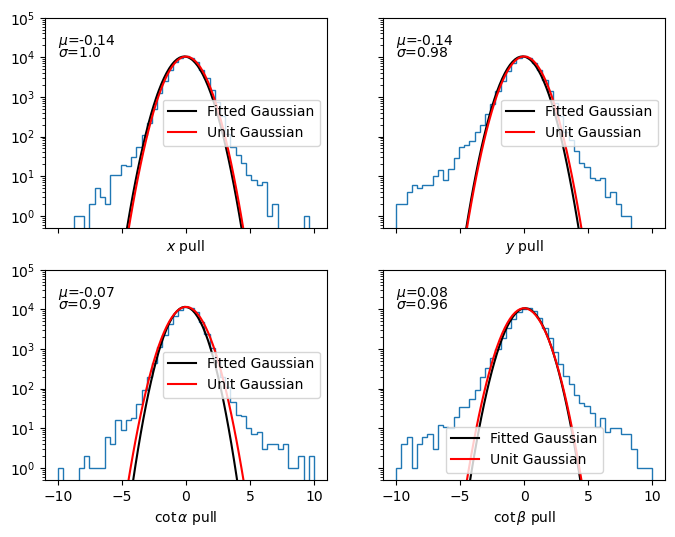

In [37]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [38]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue
angletrue


/tmp/ipykernel_2624592/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


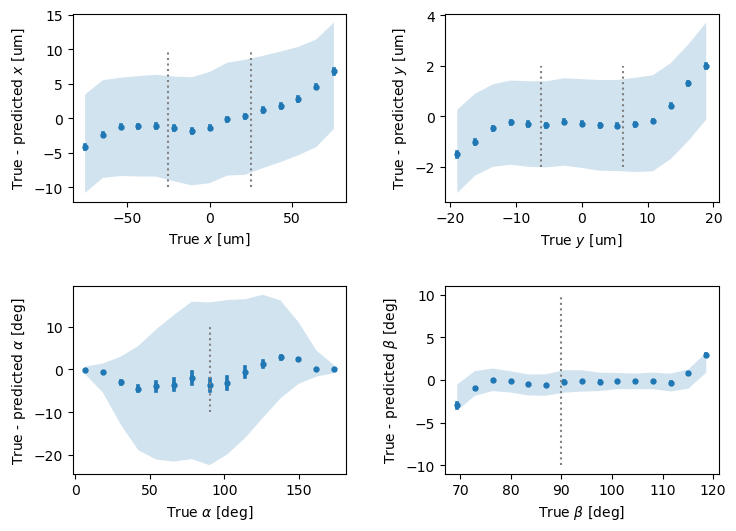

In [39]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)

/tmp/ipykernel_2624592/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue
angletrue
angletrue


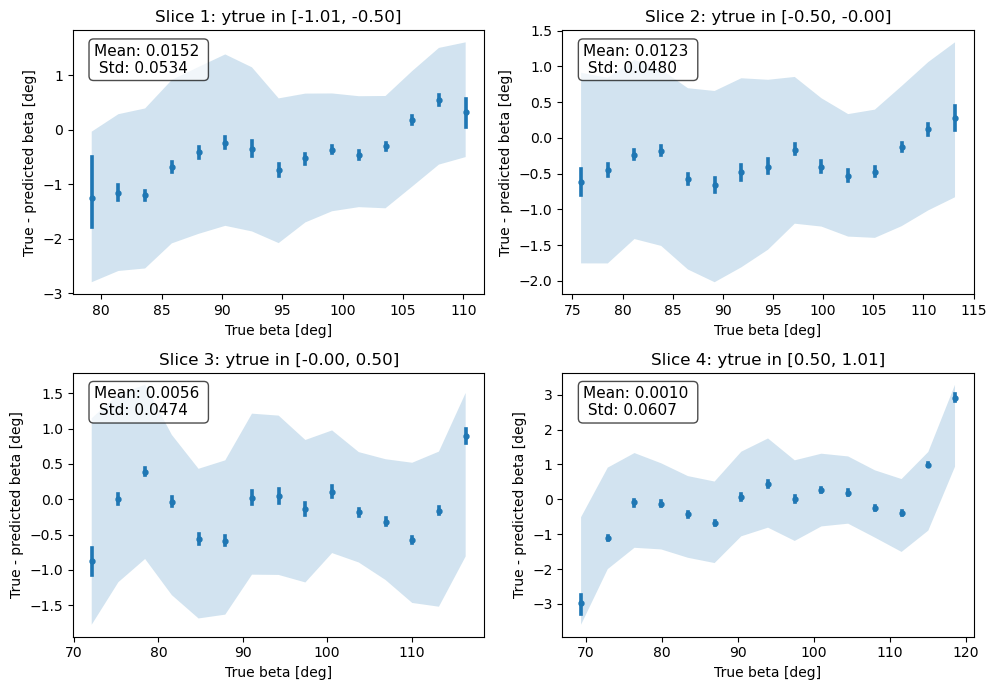

In [40]:
# Parameters
n_bins = 4
scaling = 0.5

# ytrue slices
bins = np.linspace(df['ytrue'].min(), df['ytrue'].max(), n_bins + 1)
df['y_bin'] = pd.cut(df['ytrue'], bins=bins, labels=False)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

for i in range(n_bins):
    thisdf = df[df['y_bin'] == i].copy()
    
    # Residual calculation
    residuals = thisdf['cotBtrue'] - thisdf['cotB']
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    
    ax = axs[i // 2, i % 2]
    residual_plot_deg(ax, thisdf, 'cotBtrue', 'cotB', r'beta [deg]', scaling=scaling)
    ax.set_title(f'Slice {i+1}: ytrue in [{bins[i]:.2f}, {bins[i+1]:.2f}]')

    stats_text = f'Mean: {mean_residual:.4f} \n Std: {std_residual:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()